In [94]:
import matplotlib.pyplot as plt
import numpy as np

In [95]:
slax = [0.12, 0.30, 0.55, 0.66, 0.01, 0.03, 0.08, 0.16, 0.14, 0.31, 1.09, 2.45, 0.04, 0.07, 0.27, 0.58]
spyx = [0.15, 0.30, 0.57, 0.0, 0.02, 0.03, 0.10, 0.19, 0.19, 0.36, 1.14, 2.65, 0.01, 0.11, 0.33, 0.64]
spikingjelly = [0.08, 0.26, 0.93, 0.0, .004, 0.03, 0.12, 0.30, 3.14, 5.37, 10.4, 16.7, 0.0, 0.0, 0.0, 0.0]
snntorch = [1.20, 1.43, 4.35, 9.27, 1.07, 1.06, 1.38, 2.31, 1.96, 2.07, 3.31, 5.97, 3.29, 3.23, 3.28, 3.41]
rockpool = [0.65, 1.27, 0.0, 0.0, 0.07, 0.22, 0.70, 1.35, 8.28, 13.4, 24.1, 37.8, 0.0, 0.0, 0.0, 0.0]
rockpool_jax = [0.45, 1.17, 0.0, 0.0, 0.04, 0.09, 0.24, 0.44, 2.67, 4.12, 8.86, 16.5, 0.13, 0.29, 0.0, 0.0]
norse = [4.20, 7.74, 16.14, 0.0, 1.42, 2.04, 3.49, 5.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

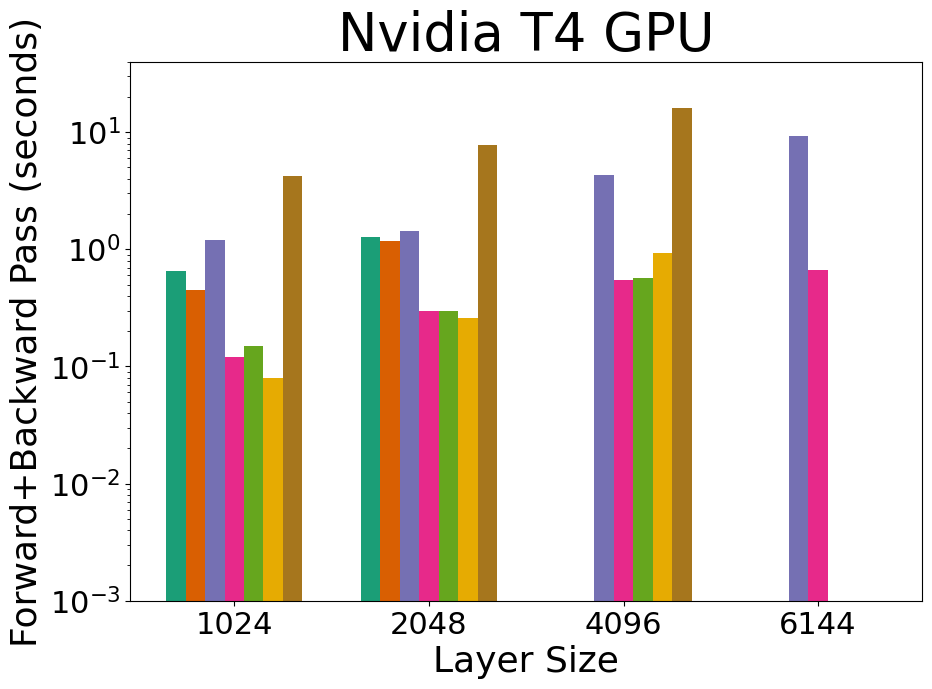

In [96]:
plt.figure(figsize=(10.22,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 0,4

plt.bar(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.bar(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.bar(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.bar(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.bar(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.bar(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.bar(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.xticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Layer Size",fontsize=26) 
plt.ylabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("Nvidia T4 GPU",fontsize=38) 
plt.yscale('log')
plt.ylim((0.001,40))
#plt.legend(loc='lower right',fontsize=21) 
plt.show() 

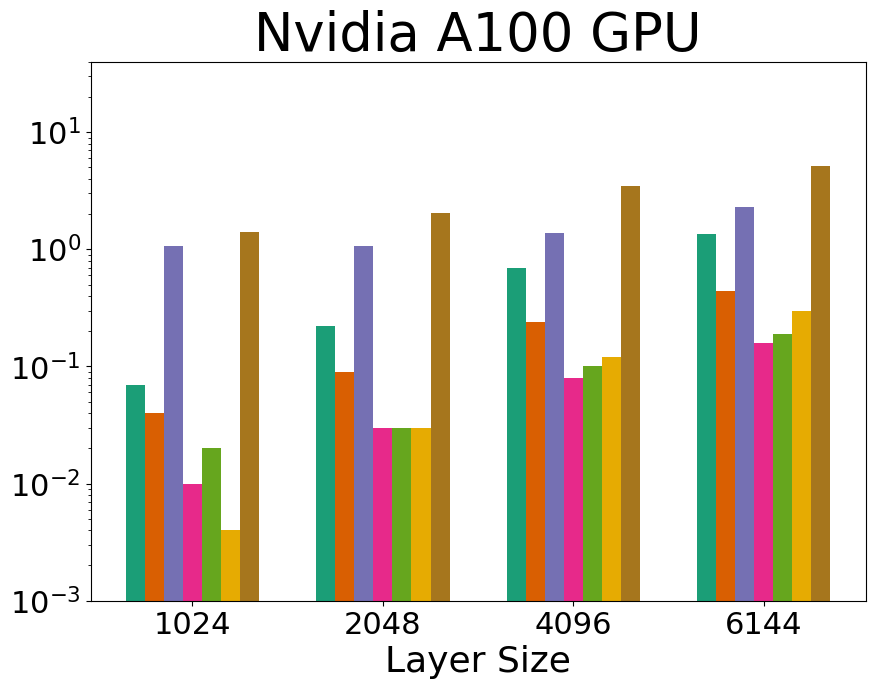

In [97]:
plt.figure(figsize=(10,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 4,8

plt.bar(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.bar(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.bar(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.bar(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.bar(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.bar(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.bar(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.xticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Layer Size",fontsize=26) 
#plt.ylabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("Nvidia A100 GPU",fontsize=38) 
plt.yscale('log')
plt.ylim((0.001,40))
#plt.legend(loc='lower right',fontsize=21) 
plt.show() 

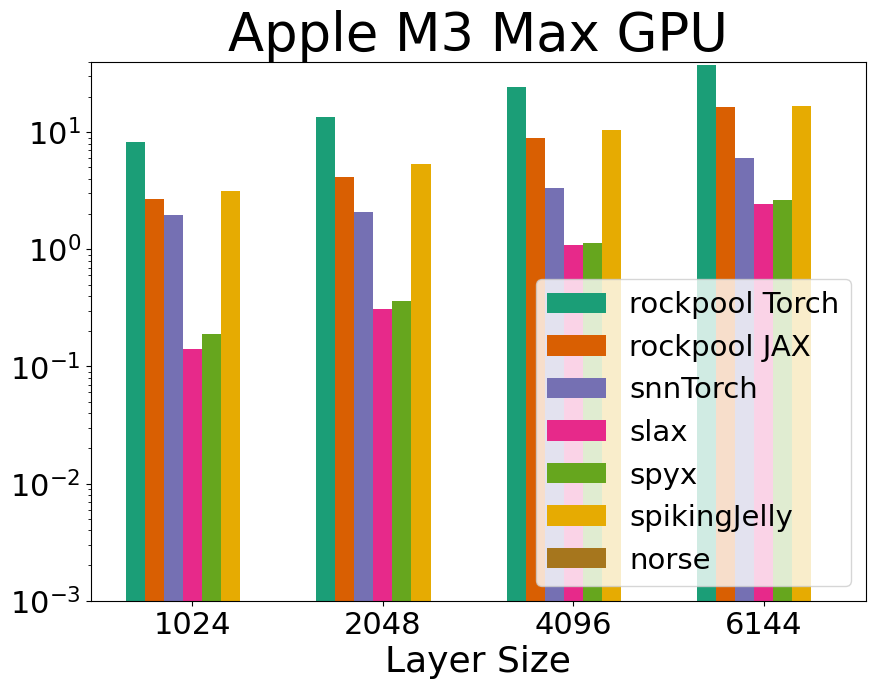

In [98]:
plt.figure(figsize=(10,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 8,12

plt.bar(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.bar(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.bar(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.bar(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.bar(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.bar(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.bar(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.xticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Layer Size",fontsize=26) 
#plt.ylabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("Apple M3 Max GPU",fontsize=38) 
plt.yscale('log')
plt.ylim((0.001,40))
plt.legend(loc='lower right',fontsize=21) 
plt.show() 

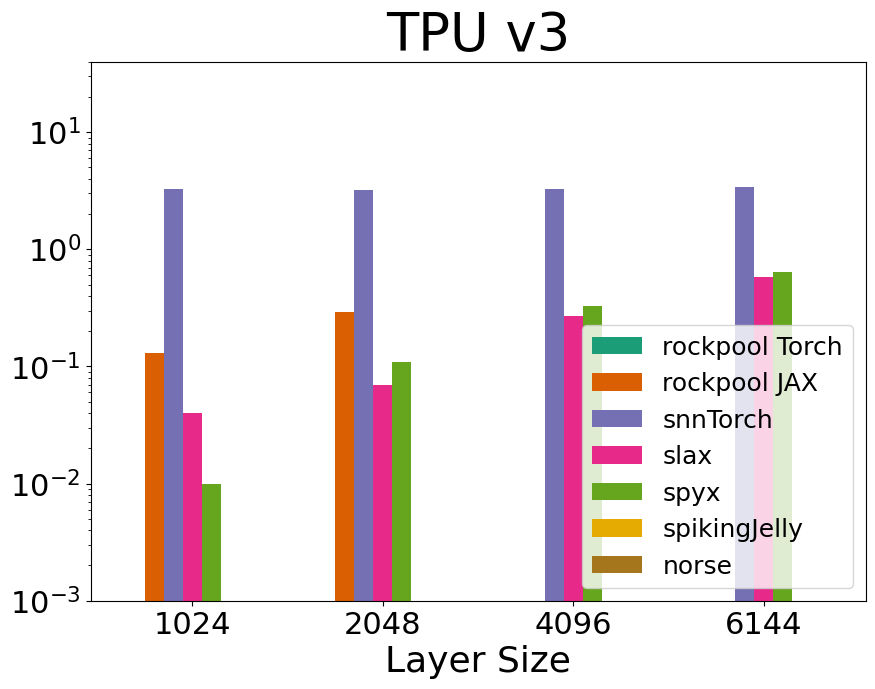

In [100]:
plt.figure(figsize=(10,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 12,16

plt.bar(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.bar(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.bar(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.bar(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.bar(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.bar(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.bar(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.xticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Layer Size",fontsize=26) 
#plt.ylabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("TPU v3",fontsize=38) 
plt.yscale('log')
plt.ylim((0.001,40))
plt.legend(loc='lower right',fontsize=18) 
plt.show() 

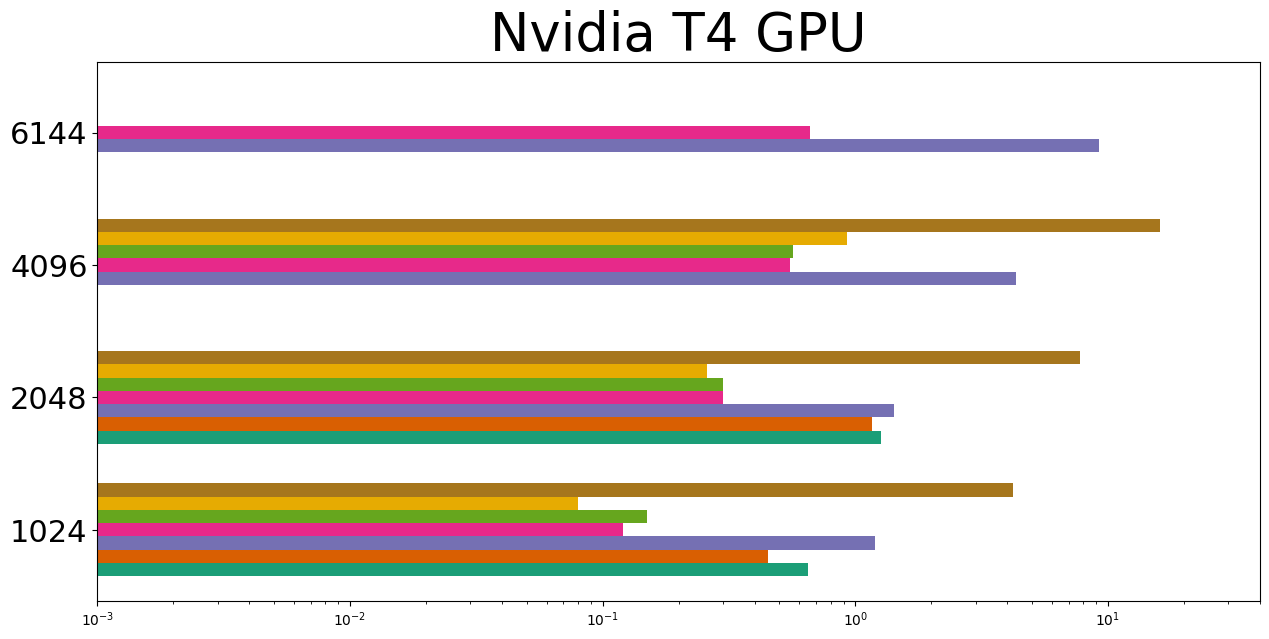

In [120]:
plt.figure(figsize=(15,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 0,4

plt.barh(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.barh(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.barh(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.barh(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.barh(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.barh(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.barh(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.yticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
#plt.xlabel("Layer Size",fontsize=26) 
#plt.xlabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("Nvidia T4 GPU",fontsize=38) 
plt.xscale('log')
plt.xlim((0.001,40))
#plt.legend(loc='lower right',fontsize=21) 
plt.show() 

In [164]:
X_axis

array([0, 1, 2, 3])

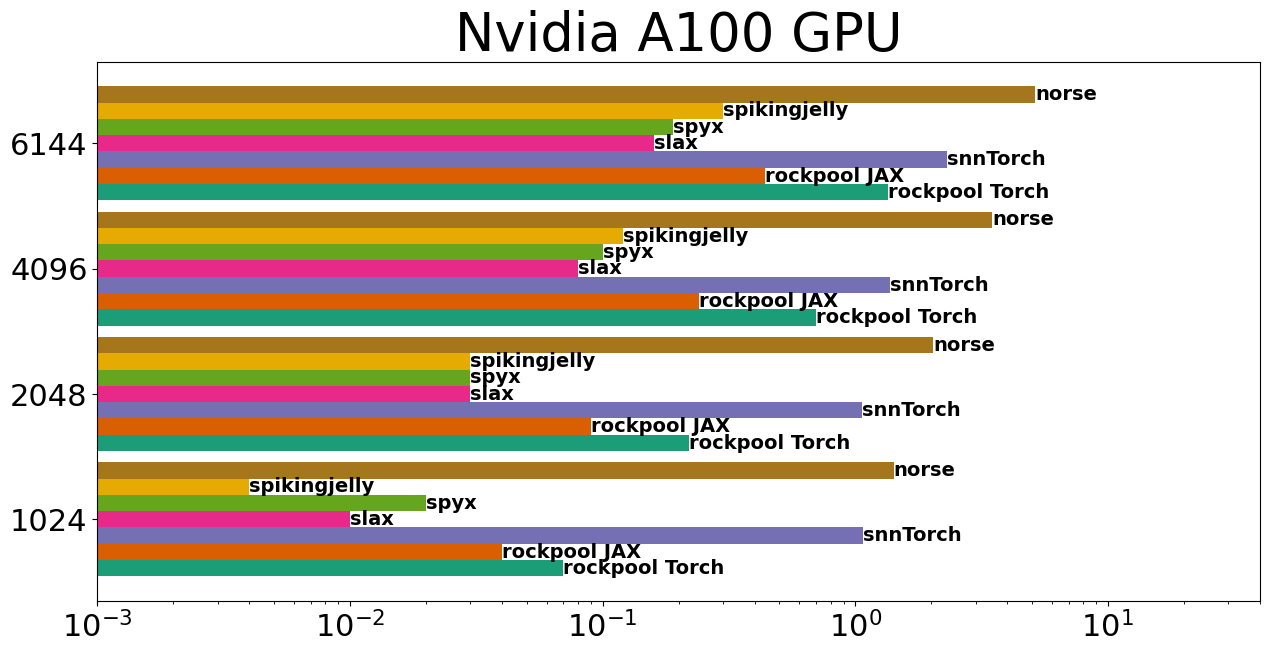

In [191]:
plt.figure(figsize=(15,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 4,8

plt.barh(X_axis - 0.39, rockpool[s:t], 0.13, label = 'rockpool Torch',color=colors[0])
plt.barh(X_axis - 0.26, rockpool_jax[s:t], 0.13, label = 'rockpool JAX',color=colors[1])
plt.barh(X_axis - 0.13, snntorch[s:t], 0.13, label = 'snnTorch',color=colors[2])
plt.barh(X_axis + 0.0, slax[s:t], 0.13, label = 'slax',color=colors[3]) 
plt.barh(X_axis + 0.13, spyx[s:t], 0.13, label = 'spyx',color=colors[4])
plt.barh(X_axis + 0.26, spikingjelly[s:t], 0.13, label = 'spikingJelly',color=colors[5]) 
plt.barh(X_axis + 0.39, norse[s:t], 0.13, label = 'norse',color=colors[6])

for i in range(4):
    plt.text(rockpool[i+s],X_axis[i]-0.39,'rockpool Torch',va='center',fontweight='bold',fontsize=14)
for i in range(4):
    plt.text(rockpool_jax[i+s],X_axis[i]-0.26,'rockpool JAX',va='center',fontweight='bold',fontsize=14)
for i in range(4):
    plt.text(snntorch[i+s],X_axis[i]-0.13,'snnTorch',va='center',fontweight='bold',fontsize=14)
for i in range(4):
    plt.text(slax[i+s],X_axis[i]-0.0,'slax',va='center',fontweight='bold',fontsize=14)
for i in range(4):
    plt.text(spyx[i+s],X_axis[i]+0.13,'spyx',va='center',fontweight='bold',fontsize=14)
for i in range(4):
    plt.text(spikingjelly[i+s],X_axis[i]+0.26,'spikingjelly',va='center',fontweight='bold',fontsize=14)
for i in range(4):
    plt.text(norse[i+s],X_axis[i]+0.39,'norse',va='center',fontweight='bold',fontsize=14)

plt.yticks(X_axis, X,fontsize=22)
plt.xticks(fontsize=22)
#plt.yticks(fontsize=22)
#plt.xlabel("Layer Size",fontsize=26) 
#plt.xlabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("Nvidia A100 GPU",fontsize=38) 
plt.xscale('log')
plt.xlim((0.001,40))
#plt.legend(loc='lower right',fontsize=21) 
plt.show() 

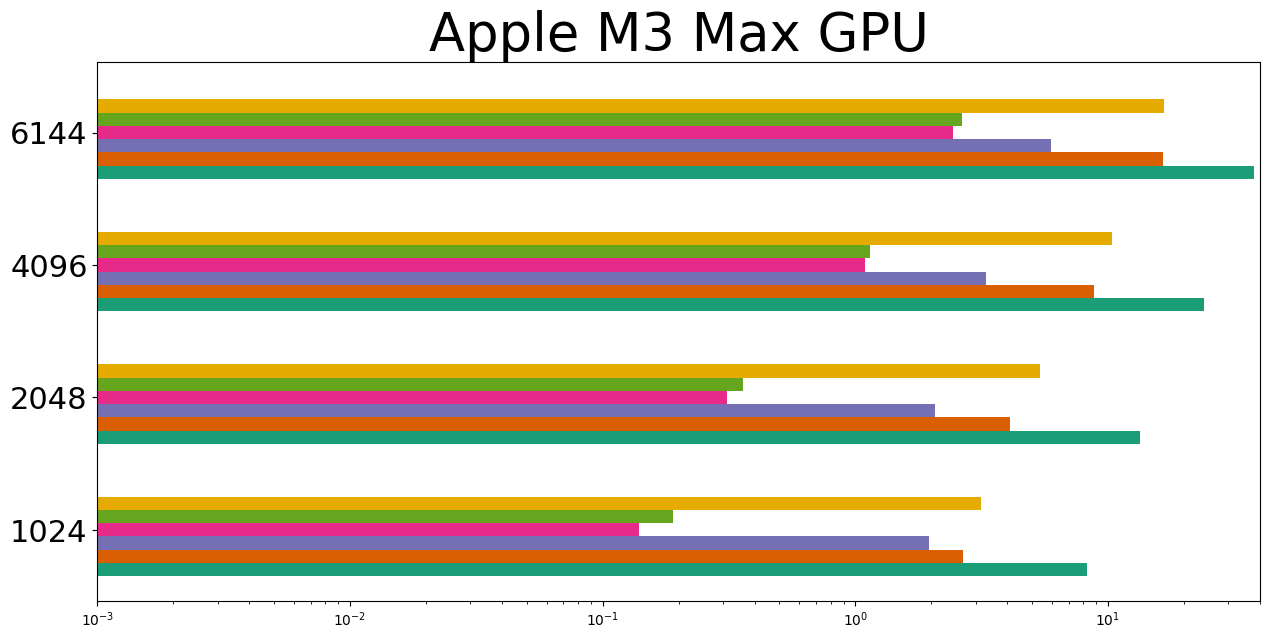

In [123]:
plt.figure(figsize=(15,7))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 8,12

plt.barh(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.barh(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.barh(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.barh(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.barh(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.barh(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.barh(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.yticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
#plt.xlabel("Layer Size",fontsize=26) 
#plt.xlabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("Apple M3 Max GPU",fontsize=38) 
plt.xscale('log')
plt.xlim((0.001,40))
#plt.legend(loc='lower right',fontsize=21) 
plt.show() 

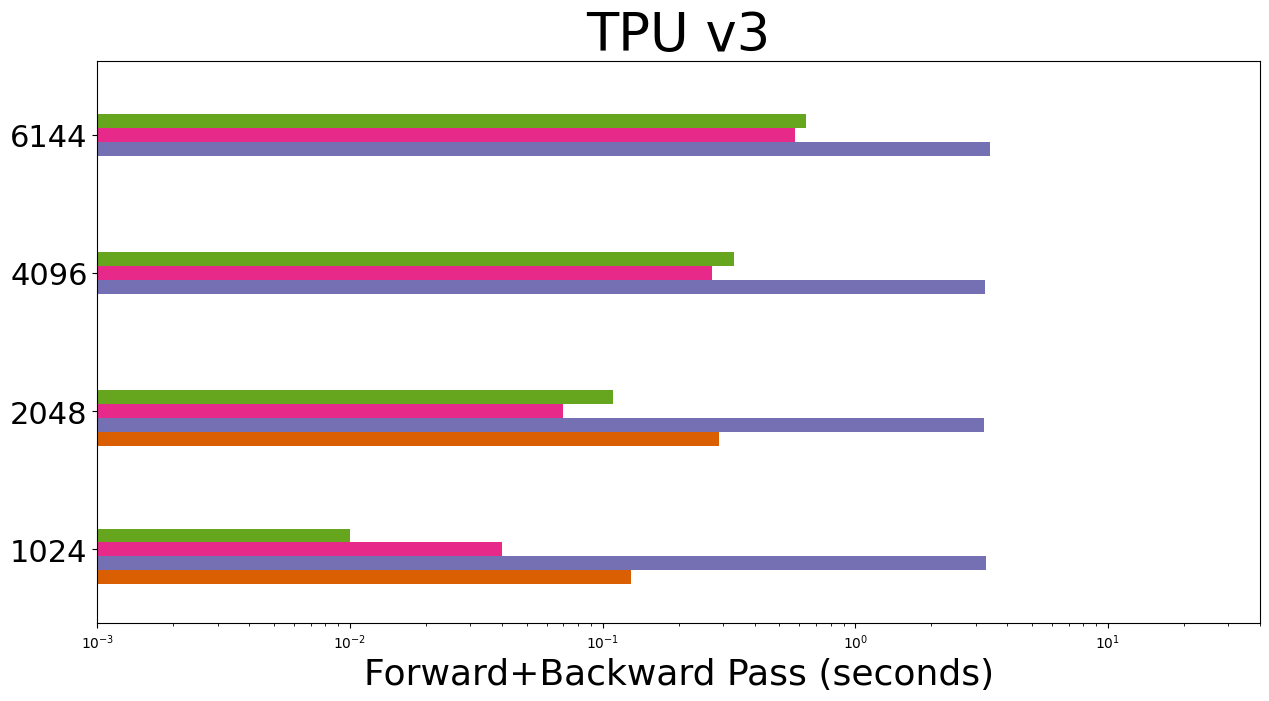

In [130]:
plt.figure(figsize=(15,7.3))
X = ['1024','2048','4096','6144']
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
  
X_axis = np.arange(len(X))
s,t = 12,16

plt.barh(X_axis - 0.3, rockpool[s:t], 0.1, label = 'rockpool Torch',color=colors[0])
plt.barh(X_axis - 0.2, rockpool_jax[s:t], 0.1, label = 'rockpool JAX',color=colors[1])
plt.barh(X_axis - 0.1, snntorch[s:t], 0.1, label = 'snnTorch',color=colors[2])
plt.barh(X_axis + 0.0, slax[s:t], 0.1, label = 'slax',color=colors[3]) 
plt.barh(X_axis + 0.1, spyx[s:t], 0.1, label = 'spyx',color=colors[4])
plt.barh(X_axis + 0.2, spikingjelly[s:t], 0.1, label = 'spikingJelly',color=colors[5]) 
plt.barh(X_axis + 0.3, norse[s:t], 0.1, label = 'norse',color=colors[6])



plt.yticks(X_axis, X,fontsize=22)
plt.yticks(fontsize=22)
#plt.ylabel("Layer Size",fontsize=26) 
plt.xlabel("Forward+Backward Pass (seconds)",fontsize=26) 
plt.title("TPU v3",fontsize=38) 
plt.xscale('log')
plt.xlim((0.001,40))
#plt.legend(loc='lower right',fontsize=21) 
plt.show() 